[link text](https://)  
#Experiment with P Oversample , NP Regular 
###3 OM - Dataset , Camping, Bank
###1 OM - Testing - Library Management 
### Total instances - 188 

### P samples - 122 
### NP samples - 69 

Oversampling: Repeated P samples and 100 new samples from Ecommerce-OM

## Setup (installing necessary libraries)

In [1]:
#!pip install "tensorflow-text>=2.10"
#!pip install einops

#Importing Libraries 

In [ ]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

#Defining the Shapechecker

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Loading the Dataset

In [ ]:
import pandas as pd
ORM_data = pd.read_csv('3-OM.csv')


#Reading Dat from Dataset

In [ ]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
1,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
2,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
3,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
4,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...


In [ ]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [ ]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [ ]:
target_raw =  Y
context_raw = X
#print(context_raw[-1])

In [ ]:
#print(target_raw[-1])

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  #print(example_context_strings[:5])
  #print()
  #print(example_target_strings[:5])
  break

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [ ]:
example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

#example_text = tf.constant('class1,table2,obj1,atr1')
#print(example_text.numpy())
#print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

In [ ]:
#import re

#def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  #text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #pattern = '\s+'
  #re.split(pattern, text, maxsplit=2)
  #text = tf.strings.regex_replace(text, '\s+', '')
  #tf.strings.split(text, sep=', ', maxsplit=2, name=None)
  #tf.strings.split (text, sep='\s+', maxsplit=2, name=None)
  #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  #tf.strings.split(text, ',')
  #text = tf.strings.split(text, sep=None, maxsplit=-1, name=None)
  #text.tf.strings.split(', ')

  # Add spaces around punctuation.
  #text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  #text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  #return text

def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'\0')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text



In [ ]:
#print(example_text.numpy().decode())
#print(tf_lower_and_split_punct(example_text).numpy().decode())

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
#context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
#target_text_processor.get_vocabulary()[:10]

Now these layers can convert a batch of strings into a batch of token IDs:

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 42, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

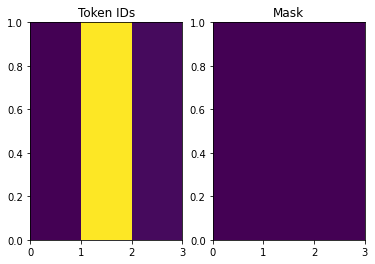

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 69  3]

[ 2 69]
[69  3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [ ]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
       query=x,
       value=context,
      return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
  #Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                 output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

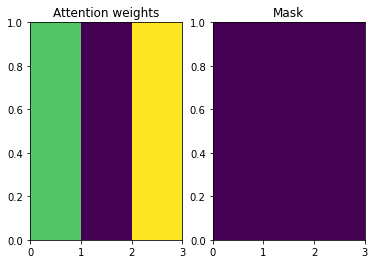

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 121)


#### Inference

For inference usage couple more methods.

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex

## The model


In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 121)


### Train

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [ ]:
model.compile(optimizer='Adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 4.7957907, 'expected_acc': 0.008264462809917356}

That should roughly match the values returned by running a few steps of evaluation:

In [ ]:
model.evaluate(val_ds, steps=60, return_dict=True)

40/60 [===================>..........] - ETA: 0s - loss: 4.8004 - masked_acc: 0.0000e+00 - masked_loss: 4.8004

60/60 [==============================] - 8s 15ms/step - loss: 4.8145 - masked_acc: 0.0000e+00 - masked_loss: 4.8145


{'loss': 4.814493179321289,
 'masked_acc': 0.0,
 'masked_loss': 4.814493179321289}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 60,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 3.2612 - masked_acc: 0.4899 - masked_loss: 3.2612

100/100 [==============================] - 19s 32ms/step - loss: 3.2616 - masked_acc: 0.4900 - masked_loss: 3.2616 - val_loss: 3.1481 - val_masked_acc: 0.5000 - val_masked_loss: 3.1481
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.0350 - masked_acc: 0.5000 - masked_loss: 3.0350

100/100 [==============================] - 3s 30ms/step - loss: 3.0350 - masked_acc: 0.5000 - masked_loss: 3.0350
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.0090 - masked_acc: 0.5050 - masked_loss: 3.0090

100/100 [==============================] - 3s 34ms/step - loss: 3.0090 - masked_acc: 0.5050 - masked_loss: 3.0090
Epoch 4/100
 98/100 [============================>.] - ETA: 0s - loss: 2.6129 - masked_acc: 0.5051 - masked_loss: 2.6129

100/100 [==============================] - 3s 25ms/step - loss: 2.5970 - masked_acc: 0.5100 - masked_loss: 2.5970
Epoch 5/100
 98/100 [============================>.] - ETA: 0s - loss: 2.3990 - masked_acc: 0.5153 - masked_loss: 2.3990

100/100 [==============================] - 3s 25ms/step - loss: 2.3977 - masked_acc: 0.5150 - masked_loss: 2.3977
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 2.2177 - masked_acc: 0.5400 - masked_loss: 2.2177

100/100 [==============================] - 2s 25ms/step - loss: 2.2177 - masked_acc: 0.5400 - masked_loss: 2.2177
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 2.2413 - masked_acc: 0.5253 - masked_loss: 2.2413

100/100 [==============================] - 4s 37ms/step - loss: 2.2426 - masked_acc: 0.5250 - masked_loss: 2.2426
Epoch 8/100
 98/100 [============================>.] - ETA: 0s - loss: 1.4776 - masked_acc: 0.6429 - masked_loss: 1.4776

100/100 [==============================] - 3s 25ms/step - loss: 1.4889 - masked_acc: 0.6400 - masked_loss: 1.4889
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 1.1921 - masked_acc: 0.7150 - masked_loss: 1.1921

100/100 [==============================] - 3s 25ms/step - loss: 1.1921 - masked_acc: 0.7150 - masked_loss: 1.1921
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 1.0287 - masked_acc: 0.7000 - masked_loss: 1.0287

100/100 [==============================] - 2s 24ms/step - loss: 1.0287 - masked_acc: 0.7000 - masked_loss: 1.0287
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.4600 - masked_acc: 0.8700 - masked_loss: 0.4600

100/100 [==============================] - 2s 25ms/step - loss: 0.4600 - masked_acc: 0.8700 - masked_loss: 0.4600
Epoch 12/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2931 - masked_acc: 0.9343 - masked_loss: 0.2931

100/100 [==============================] - 4s 40ms/step - loss: 0.2912 - masked_acc: 0.9350 - masked_loss: 0.2912
Epoch 13/100
 98/100 [============================>.] - ETA: 0s - loss: 0.1462 - masked_acc: 0.9847 - masked_loss: 0.1462

100/100 [==============================] - 3s 25ms/step - loss: 0.1440 - masked_acc: 0.9850 - masked_loss: 0.1440
Epoch 14/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0518 - masked_acc: 0.9949 - masked_loss: 0.0518

100/100 [==============================] - 2s 24ms/step - loss: 0.0511 - masked_acc: 0.9950 - masked_loss: 0.0511
Epoch 15/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0197 - masked_acc: 1.0000 - masked_loss: 0.0197

100/100 [==============================] - 3s 26ms/step - loss: 0.0197 - masked_acc: 1.0000 - masked_loss: 0.0197
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 0.0404 - masked_acc: 0.9900 - masked_loss: 0.0404

100/100 [==============================] - 4s 36ms/step - loss: 0.0404 - masked_acc: 0.9900 - masked_loss: 0.0404
Epoch 17/100
100/100 [==============================] - ETA: 0s - loss: 0.0152 - masked_acc: 1.0000 - masked_loss: 0.0152

100/100 [==============================] - 3s 29ms/step - loss: 0.0152 - masked_acc: 1.0000 - masked_loss: 0.0152
Epoch 18/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0506 - masked_acc: 0.9898 - masked_loss: 0.0506

100/100 [==============================] - 3s 25ms/step - loss: 0.0499 - masked_acc: 0.9900 - masked_loss: 0.0499
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.0341 - masked_acc: 0.9950 - masked_loss: 0.0341

100/100 [==============================] - 3s 25ms/step - loss: 0.0341 - masked_acc: 0.9950 - masked_loss: 0.0341
Epoch 20/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0180 - masked_acc: 0.9949 - masked_loss: 0.0180

100/100 [==============================] - 3s 26ms/step - loss: 0.0179 - masked_acc: 0.9950 - masked_loss: 0.0179
Epoch 21/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - masked_acc: 0.9949 - masked_loss: 0.0269

100/100 [==============================] - 5s 46ms/step - loss: 0.0268 - masked_acc: 0.9950 - masked_loss: 0.0268
Epoch 22/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0357 - masked_acc: 0.9899 - masked_loss: 0.0357

100/100 [==============================] - 4s 42ms/step - loss: 0.0355 - masked_acc: 0.9900 - masked_loss: 0.0355
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 0.0167 - masked_acc: 0.9950 - masked_loss: 0.0167

100/100 [==============================] - 5s 48ms/step - loss: 0.0167 - masked_acc: 0.9950 - masked_loss: 0.0167
Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0241 - masked_acc: 0.9949 - masked_loss: 0.0241

100/100 [==============================] - 5s 50ms/step - loss: 0.0240 - masked_acc: 0.9950 - masked_loss: 0.0240
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.0167 - masked_acc: 0.9950 - masked_loss: 0.0167

100/100 [==============================] - 3s 25ms/step - loss: 0.0167 - masked_acc: 0.9950 - masked_loss: 0.0167
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0330 - masked_acc: 0.9899 - masked_loss: 0.0330

100/100 [==============================] - 3s 25ms/step - loss: 0.0327 - masked_acc: 0.9900 - masked_loss: 0.0327
Epoch 27/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0245 - masked_acc: 0.9899 - masked_loss: 0.0245

100/100 [==============================] - 3s 25ms/step - loss: 0.0243 - masked_acc: 0.9900 - masked_loss: 0.0243
Epoch 28/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0202 - masked_acc: 0.9949 - masked_loss: 0.0202

100/100 [==============================] - 4s 38ms/step - loss: 0.0200 - masked_acc: 0.9950 - masked_loss: 0.0200
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.0285 - masked_acc: 0.9900 - masked_loss: 0.0285

100/100 [==============================] - 2s 25ms/step - loss: 0.0285 - masked_acc: 0.9900 - masked_loss: 0.0285
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.0094 - masked_acc: 0.9950 - masked_loss: 0.0094

100/100 [==============================] - 3s 26ms/step - loss: 0.0094 - masked_acc: 0.9950 - masked_loss: 0.0094
Epoch 31/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0180 - masked_acc: 0.9949 - masked_loss: 0.0180

100/100 [==============================] - 3s 25ms/step - loss: 0.0179 - masked_acc: 0.9950 - masked_loss: 0.0179
Epoch 32/100
100/100 [==============================] - ETA: 0s - loss: 0.0326 - masked_acc: 0.9850 - masked_loss: 0.0326

100/100 [==============================] - 3s 31ms/step - loss: 0.0326 - masked_acc: 0.9850 - masked_loss: 0.0326
Epoch 33/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0170 - masked_acc: 0.9949 - masked_loss: 0.0170

100/100 [==============================] - 3s 33ms/step - loss: 0.0169 - masked_acc: 0.9950 - masked_loss: 0.0169
Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0116 - masked_acc: 0.9949 - masked_loss: 0.0116

100/100 [==============================] - 3s 27ms/step - loss: 0.0116 - masked_acc: 0.9950 - masked_loss: 0.0116
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.0185 - masked_acc: 0.9950 - masked_loss: 0.0185

100/100 [==============================] - 3s 26ms/step - loss: 0.0185 - masked_acc: 0.9950 - masked_loss: 0.0185
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.0226 - masked_acc: 0.9900 - masked_loss: 0.0226

100/100 [==============================] - 3s 25ms/step - loss: 0.0226 - masked_acc: 0.9900 - masked_loss: 0.0226
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 0.0150 - masked_acc: 0.9900 - masked_loss: 0.0150

100/100 [==============================] - 4s 38ms/step - loss: 0.0150 - masked_acc: 0.9900 - masked_loss: 0.0150
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 0.0320 - masked_acc: 0.9950 - masked_loss: 0.0320

100/100 [==============================] - 3s 26ms/step - loss: 0.0320 - masked_acc: 0.9950 - masked_loss: 0.0320
Epoch 39/100
100/100 [==============================] - ETA: 0s - loss: 0.0060 - masked_acc: 0.9950 - masked_loss: 0.0060

100/100 [==============================] - 3s 25ms/step - loss: 0.0060 - masked_acc: 0.9950 - masked_loss: 0.0060
Epoch 40/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0218 - masked_acc: 0.9898 - masked_loss: 0.0218

100/100 [==============================] - 2s 25ms/step - loss: 0.0214 - masked_acc: 0.9900 - masked_loss: 0.0214
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.0154 - masked_acc: 0.9950 - masked_loss: 0.0154

100/100 [==============================] - 3s 29ms/step - loss: 0.0154 - masked_acc: 0.9950 - masked_loss: 0.0154
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.0143 - masked_acc: 0.9950 - masked_loss: 0.0143

100/100 [==============================] - 3s 34ms/step - loss: 0.0143 - masked_acc: 0.9950 - masked_loss: 0.0143
Epoch 43/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0029 - masked_acc: 1.0000 - masked_loss: 0.0029

100/100 [==============================] - 3s 25ms/step - loss: 0.0029 - masked_acc: 1.0000 - masked_loss: 0.0029
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 0.0151 - masked_acc: 0.9950 - masked_loss: 0.0151

100/100 [==============================] - 2s 25ms/step - loss: 0.0151 - masked_acc: 0.9950 - masked_loss: 0.0151
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 0.0072 - masked_acc: 1.0000 - masked_loss: 0.0072

100/100 [==============================] - 3s 26ms/step - loss: 0.0072 - masked_acc: 1.0000 - masked_loss: 0.0072
Epoch 46/100
100/100 [==============================] - ETA: 0s - loss: 0.0157 - masked_acc: 0.9950 - masked_loss: 0.0157

100/100 [==============================] - 4s 37ms/step - loss: 0.0157 - masked_acc: 0.9950 - masked_loss: 0.0157
Epoch 47/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0162 - masked_acc: 0.9949 - masked_loss: 0.0162

100/100 [==============================] - 3s 26ms/step - loss: 0.0160 - masked_acc: 0.9950 - masked_loss: 0.0160
Epoch 48/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0194 - masked_acc: 0.9949 - masked_loss: 0.0194

100/100 [==============================] - 2s 25ms/step - loss: 0.0192 - masked_acc: 0.9950 - masked_loss: 0.0192
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.0049 - masked_acc: 0.9950 - masked_loss: 0.0049

100/100 [==============================] - 2s 25ms/step - loss: 0.0049 - masked_acc: 0.9950 - masked_loss: 0.0049
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 0.0249 - masked_acc: 0.9850 - masked_loss: 0.0249

100/100 [==============================] - 3s 25ms/step - loss: 0.0249 - masked_acc: 0.9850 - masked_loss: 0.0249
Epoch 51/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0085 - masked_acc: 0.9949 - masked_loss: 0.0085

100/100 [==============================] - 4s 38ms/step - loss: 0.0084 - masked_acc: 0.9950 - masked_loss: 0.0084
Epoch 52/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0216 - masked_acc: 0.9847 - masked_loss: 0.0216

100/100 [==============================] - 3s 26ms/step - loss: 0.0212 - masked_acc: 0.9850 - masked_loss: 0.0212
Epoch 53/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012

100/100 [==============================] - 3s 26ms/step - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012
Epoch 54/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0190 - masked_acc: 0.9949 - masked_loss: 0.0190

100/100 [==============================] - 3s 25ms/step - loss: 0.0187 - masked_acc: 0.9950 - masked_loss: 0.0187
Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.0148 - masked_acc: 0.9950 - masked_loss: 0.0148

100/100 [==============================] - 4s 38ms/step - loss: 0.0148 - masked_acc: 0.9950 - masked_loss: 0.0148
Epoch 56/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0231 - masked_acc: 0.9848 - masked_loss: 0.0231

100/100 [==============================] - 3s 27ms/step - loss: 0.0229 - masked_acc: 0.9850 - masked_loss: 0.0229
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0023 - masked_acc: 1.0000 - masked_loss: 0.0023

100/100 [==============================] - 4s 36ms/step - loss: 0.0022 - masked_acc: 1.0000 - masked_loss: 0.0022
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.0159 - masked_acc: 0.9950 - masked_loss: 0.0159

100/100 [==============================] - 3s 28ms/step - loss: 0.0159 - masked_acc: 0.9950 - masked_loss: 0.0159
Epoch 59/100
 99/100 [============================>.] - ETA: 0s - loss: 0.9510 - masked_acc: 0.8232 - masked_loss: 0.9510

100/100 [==============================] - 4s 45ms/step - loss: 0.9691 - masked_acc: 0.8200 - masked_loss: 0.9691
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 1.5652 - masked_acc: 0.6162 - masked_loss: 1.5652

100/100 [==============================] - 3s 26ms/step - loss: 1.5820 - masked_acc: 0.6150 - masked_loss: 1.5820
Epoch 61/100
100/100 [==============================] - ETA: 0s - loss: 1.4528 - masked_acc: 0.6450 - masked_loss: 1.4528

100/100 [==============================] - 3s 25ms/step - loss: 1.4528 - masked_acc: 0.6450 - masked_loss: 1.4528
Epoch 62/100
 98/100 [============================>.] - ETA: 0s - loss: 0.4252 - masked_acc: 0.8673 - masked_loss: 0.4252

100/100 [==============================] - 3s 25ms/step - loss: 0.4225 - masked_acc: 0.8700 - masked_loss: 0.4225
Epoch 63/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2151 - masked_acc: 0.9343 - masked_loss: 0.2151

100/100 [==============================] - 3s 29ms/step - loss: 0.2201 - masked_acc: 0.9300 - masked_loss: 0.2201
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0522 - masked_acc: 0.9949 - masked_loss: 0.0522

100/100 [==============================] - 4s 37ms/step - loss: 0.0517 - masked_acc: 0.9950 - masked_loss: 0.0517
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 0.0255 - masked_acc: 0.9900 - masked_loss: 0.0255

100/100 [==============================] - 3s 34ms/step - loss: 0.0255 - masked_acc: 0.9900 - masked_loss: 0.0255
Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 0.0068 - masked_acc: 1.0000 - masked_loss: 0.0068

100/100 [==============================] - 2s 25ms/step - loss: 0.0068 - masked_acc: 1.0000 - masked_loss: 0.0068
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.0254 - masked_acc: 0.9900 - masked_loss: 0.0254

100/100 [==============================] - 3s 28ms/step - loss: 0.0254 - masked_acc: 0.9900 - masked_loss: 0.0254
Epoch 68/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0119 - masked_acc: 0.9949 - masked_loss: 0.0119

100/100 [==============================] - 4s 35ms/step - loss: 0.0118 - masked_acc: 0.9950 - masked_loss: 0.0118
Epoch 69/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0253 - masked_acc: 0.9848 - masked_loss: 0.0253

100/100 [==============================] - 2s 24ms/step - loss: 0.0251 - masked_acc: 0.9850 - masked_loss: 0.0251
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0053 - masked_acc: 1.0000 - masked_loss: 0.0053

100/100 [==============================] - 2s 24ms/step - loss: 0.0053 - masked_acc: 1.0000 - masked_loss: 0.0053
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.0226 - masked_acc: 0.9900 - masked_loss: 0.0226

100/100 [==============================] - 3s 25ms/step - loss: 0.0226 - masked_acc: 0.9900 - masked_loss: 0.0226
Epoch 72/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0186 - masked_acc: 0.9949 - masked_loss: 0.0186

100/100 [==============================] - 3s 35ms/step - loss: 0.0184 - masked_acc: 0.9950 - masked_loss: 0.0184
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.0075 - masked_acc: 0.9950 - masked_loss: 0.0075

100/100 [==============================] - 3s 28ms/step - loss: 0.0075 - masked_acc: 0.9950 - masked_loss: 0.0075
Epoch 74/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0174 - masked_acc: 0.9898 - masked_loss: 0.0174

100/100 [==============================] - 2s 25ms/step - loss: 0.0171 - masked_acc: 0.9900 - masked_loss: 0.0171
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 0.0163 - masked_acc: 0.9900 - masked_loss: 0.0163

100/100 [==============================] - 3s 25ms/step - loss: 0.0163 - masked_acc: 0.9900 - masked_loss: 0.0163
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034

100/100 [==============================] - 3s 25ms/step - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034
Epoch 77/100
100/100 [==============================] - ETA: 0s - loss: 0.0201 - masked_acc: 0.9900 - masked_loss: 0.0201

100/100 [==============================] - 4s 38ms/step - loss: 0.0201 - masked_acc: 0.9900 - masked_loss: 0.0201
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 0.0122 - masked_acc: 0.9950 - masked_loss: 0.0122

100/100 [==============================] - 3s 26ms/step - loss: 0.0122 - masked_acc: 0.9950 - masked_loss: 0.0122
Epoch 79/100
100/100 [==============================] - ETA: 0s - loss: 0.0140 - masked_acc: 0.9900 - masked_loss: 0.0140

100/100 [==============================] - 3s 25ms/step - loss: 0.0140 - masked_acc: 0.9900 - masked_loss: 0.0140
Epoch 80/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0222 - masked_acc: 0.9898 - masked_loss: 0.0222

100/100 [==============================] - 3s 25ms/step - loss: 0.0218 - masked_acc: 0.9900 - masked_loss: 0.0218
Epoch 81/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018

100/100 [==============================] - 3s 33ms/step - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018
Epoch 82/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0184 - masked_acc: 0.9898 - masked_loss: 0.0184

100/100 [==============================] - 3s 29ms/step - loss: 0.0181 - masked_acc: 0.9900 - masked_loss: 0.0181
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.0124 - masked_acc: 0.9950 - masked_loss: 0.0124

100/100 [==============================] - 3s 26ms/step - loss: 0.0124 - masked_acc: 0.9950 - masked_loss: 0.0124
Epoch 84/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0065 - masked_acc: 0.9949 - masked_loss: 0.0065

100/100 [==============================] - 2s 25ms/step - loss: 0.0064 - masked_acc: 0.9950 - masked_loss: 0.0064
Epoch 85/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034

100/100 [==============================] - 3s 25ms/step - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034
Epoch 86/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - masked_acc: 0.9848 - masked_loss: 0.0215

100/100 [==============================] - 4s 38ms/step - loss: 0.0213 - masked_acc: 0.9850 - masked_loss: 0.0213
Epoch 87/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0153 - masked_acc: 0.9949 - masked_loss: 0.0153

100/100 [==============================] - 3s 25ms/step - loss: 0.0150 - masked_acc: 0.9950 - masked_loss: 0.0150
Epoch 88/100
100/100 [==============================] - ETA: 0s - loss: 0.0138 - masked_acc: 0.9900 - masked_loss: 0.0138

100/100 [==============================] - 3s 26ms/step - loss: 0.0138 - masked_acc: 0.9900 - masked_loss: 0.0138
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021

100/100 [==============================] - 3s 27ms/step - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021
Epoch 90/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - masked_acc: 0.9899 - masked_loss: 0.0212

100/100 [==============================] - 3s 31ms/step - loss: 0.0210 - masked_acc: 0.9900 - masked_loss: 0.0210
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0088 - masked_acc: 0.9949 - masked_loss: 0.0088

100/100 [==============================] - 3s 31ms/step - loss: 0.0088 - masked_acc: 0.9950 - masked_loss: 0.0088
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 0.0167 - masked_acc: 0.9900 - masked_loss: 0.0167

100/100 [==============================] - 3s 25ms/step - loss: 0.0167 - masked_acc: 0.9900 - masked_loss: 0.0167
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 0.0017 - masked_acc: 1.0000 - masked_loss: 0.0017

100/100 [==============================] - 2s 25ms/step - loss: 0.0017 - masked_acc: 1.0000 - masked_loss: 0.0017
Epoch 94/100
100/100 [==============================] - ETA: 0s - loss: 0.0321 - masked_acc: 0.9850 - masked_loss: 0.0321

100/100 [==============================] - 3s 25ms/step - loss: 0.0321 - masked_acc: 0.9850 - masked_loss: 0.0321
Epoch 95/100
100/100 [==============================] - ETA: 0s - loss: 9.5188e-04 - masked_acc: 1.0000 - masked_loss: 9.5188e-04

100/100 [==============================] - 4s 37ms/step - loss: 9.5188e-04 - masked_acc: 1.0000 - masked_loss: 9.5188e-04
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.0104 - masked_acc: 0.9950 - masked_loss: 0.0104

100/100 [==============================] - 3s 25ms/step - loss: 0.0104 - masked_acc: 0.9950 - masked_loss: 0.0104
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.0051 - masked_acc: 1.0000 - masked_loss: 0.0051

100/100 [==============================] - 3s 25ms/step - loss: 0.0051 - masked_acc: 1.0000 - masked_loss: 0.0051
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0123 - masked_acc: 0.9949 - masked_loss: 0.0123

100/100 [==============================] - 3s 25ms/step - loss: 0.0122 - masked_acc: 0.9950 - masked_loss: 0.0122
Epoch 99/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0119 - masked_acc: 0.9899 - masked_loss: 0.0119

100/100 [==============================] - 3s 27ms/step - loss: 0.0118 - masked_acc: 0.9900 - masked_loss: 0.0118
Epoch 100/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0032 - masked_acc: 1.0000 - masked_loss: 0.0032

100/100 [==============================] - 4s 36ms/step - loss: 0.0031 - masked_acc: 1.0000 - masked_loss: 0.0031


## Plotting the Loss from Training 

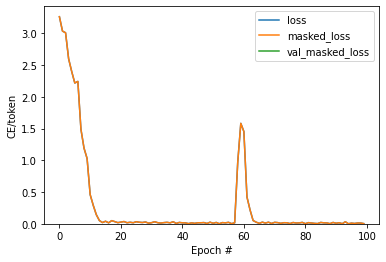

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Plotting the aacuracy from the training

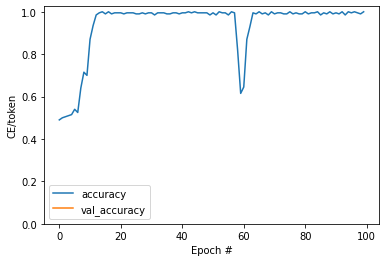

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate Module Development

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [ ]:
#Individual translator mechanism, can be used to translate each data separately


result1 = model.translate([''])

result2 = model.translate([''])

result23 = model.translate([''])

result222 = model.translate([''])
#result1[0].numpy().decode()
#result2[0].numpy().decode()



### Attention plot generation after model training has been completed

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
#model.plot_attention('') 

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
#print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

# Testing unseen samples

In [ ]:
dc = pd.read_csv('lbm_sample.csv')

In [ ]:
dc.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",0
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


### Separating Columns in X_test and y_test

In [ ]:
X_test2 = dc['OM_Regular'].values
y_test2 = dc['OM_Prediction'].values

In [ ]:
print(X_test2.shape)
print(y_test2.shape)

print("\nX data type: ", X_test2.dtype)
print("y data type: ", y_test2.dtype)

(100,)
(100,)

X data type:  object
y data type:  int64


In [ ]:
print(y_test2)

[1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [ ]:
inputs = X_test2

### Obtaining results from the model of the unseen dataset

In [ ]:
#%%time
#for t in inputs:
#  mylist_res = model.translate([t])[0].numpy().decode()
#  print(model.translate([t])[0].numpy().decode())

#print()

# Classification Report (Unseen samples)


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

### The result is obtained and captured in a separate file, labels are converted to 1 and 0 . Where 1 denotes P and 0 denotes NP. 

###READING the predicted dataset

In [ ]:
dd = pd.read_csv('lbm_sample_pred.csv')

In [ ]:
dd.head()

,OM_Regular,OM_Prediction
0,moduleom_name:0opendeclarationonesigclass1_nam...,0
1,moduleom_name:0opendeclarationonesigclass1_nam...,0
2,moduleom_name:0opendeclarationonesigclass1_nam...,0
3,moduleom_name:0opendeclarationonesigclass1_nam...,0
4,moduleom_name:0opendeclarationonesigclass1_nam...,0


In [ ]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

### Printing predicted labels

In [ ]:
print (y_test_pred2 )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
precision = precision_score(y_test2, y_test_pred2) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test2, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test2, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test2, y_test_pred2))

Testing: Precision = 1.000000
Testing: Recall = 0.200000
Testing: F1 Score = 0.333333

Confusion Matrix (Test Data):
 [[85  0]
 [12  3]]


In [ ]:
print(classification_report(y_test2,y_test_pred2))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        85
           1       1.00      0.20      0.33        15

    accuracy                           0.88       100
   macro avg       0.94      0.60      0.63       100
weighted avg       0.89      0.88      0.84       100

